Saving Detecting age and gender woman1.png to Detecting age and gender woman1 (1).png
Gender: Male
Age: 25-32 years


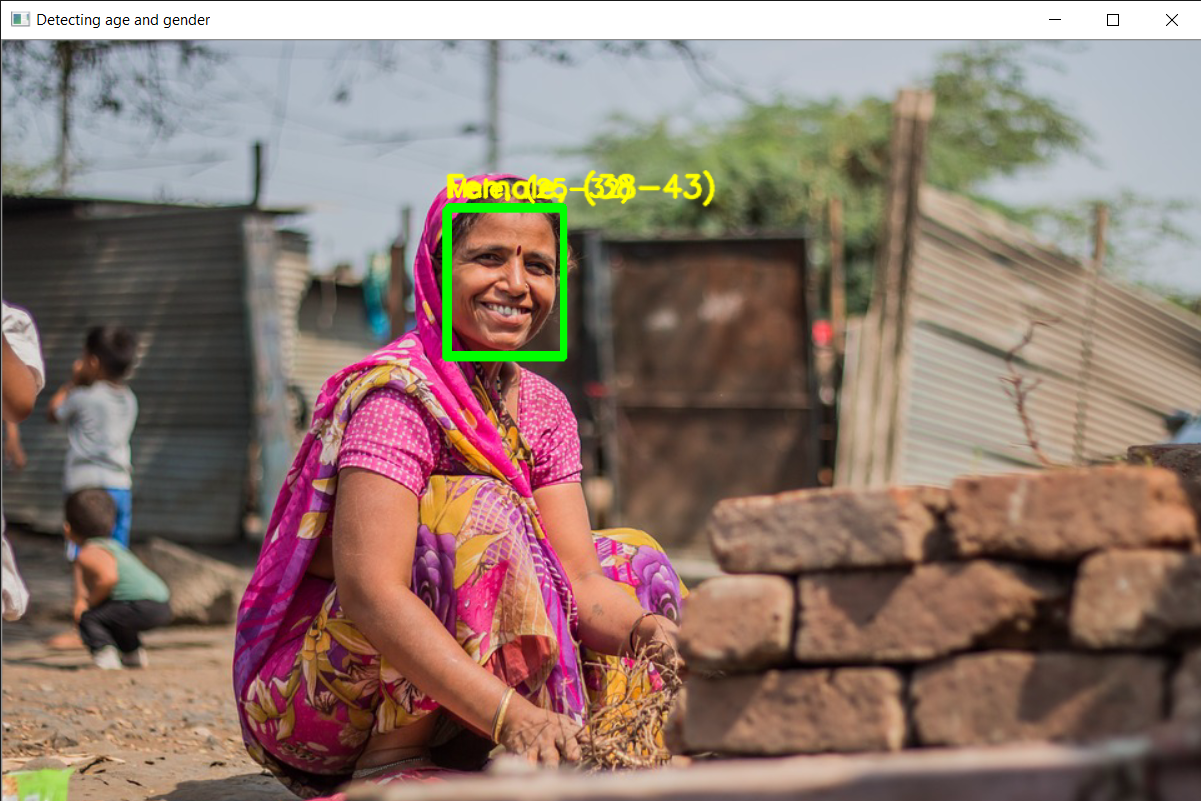

In [ ]:
# Install necessary library
!pip install opencv-python==4.8.0.76

# Import necessary libraries
import cv2
import math
from google.colab import files
from PIL import Image
from IPython.display import display

# Function to highlight detected faces
def highlightFace(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    faceBoxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            faceBoxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight / 150)), 8)
    return frameOpencvDnn, faceBoxes

# Model paths (update if needed)
faceProto = "opencv_face_detector.pbtxt"
faceModel = "opencv_face_detector_uint8.pb"
ageProto = "age_deploy.prototxt"
ageModel = "age_net.caffemodel"
genderProto = "gender_deploy.prototxt"
genderModel = "gender_net.caffemodel"

# Load models
faceNet = cv2.dnn.readNet(faceModel, faceProto)
ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)

# Age and gender lists
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Read image
frame = cv2.imread(image_path)

# Detect faces and predict age/gender
padding = 20
resultImg, faceBoxes = highlightFace(faceNet, frame)
if not faceBoxes:
    print("No face detected")

for faceBox in faceBoxes:
    face = frame[max(0, faceBox[1] - padding):
                   min(faceBox[3] + padding, frame.shape[0] - 1), max(0, faceBox[0] - padding)
                   :min(faceBox[2] + padding, frame.shape[1] - 1)]

    blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    genderNet.setInput(blob)
    genderPreds = genderNet.forward()
    gender = genderList[genderPreds[0].argmax()]
    print(f'Gender: {gender}')

    ageNet.setInput(blob)
    agePreds = ageNet.forward()
    age = ageList[agePreds[0].argmax()]
    print(f'Age: {age[1:-1]} years')

    cv2.putText(resultImg, f'{gender}, {age}', (faceBox[0], faceBox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)

# Display the output image
display(Image.fromarray(cv2.cvtColor(resultImg, cv2.COLOR_BGR2RGB)))